# The Modern Portfolio Theory and the Efficient Frontier

__Developer:__ Riccardo Poli (https://www.linkedin.com/in/riccardopoli/)

__Version control:__ 1.0 (initial release) 05 Jul 2020

__Description__
This code enables the user to easily simulate a customised portfolio and creates an interactive dashboard that can be used to decide the desired trading strategy.




In [40]:
## IMPORT NECESSARY LIBRARIES 

import pandas as pd
import numpy as np
import time
from datetime import datetime
import math
import requests
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, CrosshairTool, HoverTool, NumeralTickFormatter
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.transform import cumsum


 __Input section__

Tha user has to specify:
- the list of symbols of stocks or the ETFs of interest (e.g. "TSLA" for Tesla, Inc.; "MSFT" for Microsoft Corporation; "VOO" for the Vanguard 500 Index Fund ETF). *Recommended max number of entries: 10*
- a short description of each stocks or ETFs (in the same order as above)
- the number of portolios she/he wants to simulate. *Recommended number of portfolios to simulate > 5000*
- the range of dates where she/he wants to perform the backtesting in. *Recommended range > 3 years*
- the API key, which can be easily obtained for __free__ at https://rapidapi.com/Finnhub/api/finnhub-realtime-stock-price

In [41]:
## DEFINE ALL INPUTS

ticks = ["EMB", "AGG", "VGT", "TSLA", "AMZN"]
line_name = ["Emergin countries debt", "US debt","S&P 500 Vanguard ETF","Tesla","Amazon"]
num_port = 1000
start_date = '01/06/2015'
end_date = '27/06/2020'
api_key = "YOUR API KEY"


__Main body__

In this section, all the magic happens:
- at first, all the data (i.e. price of the stocks or the ETFs) are downloaded
- then, a specified number of portfolios are simulated, by giving a random weight to each of the stocks / ETFs
- the Sharpe ratio, the variance and the average annual return are calculated for each portfolio

*In finance, the Sharpe ratio (also known as the Sharpe index, the Sharpe measure, and the reward-to-variability ratio) measures the performance of an investment (e.g., a security or portfolio) compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment (i.e., its volatility). It represents the additional amount of return that an investor receives per unit of increase in risk.* Source: https://en.wikipedia.org/wiki/Sharpe_ratio

- finally, the dashboard is built and the results are displayed

Simply press *run* to start the simulations and see the results in an interactive plot (opens a new window). The run time varies from few seconds to minutes depending on the size of the list of stocks and ETFs to download, the range of dates, and the number of portfolios to simulate.

The dashboard will look like this and it will contain interactable elements. 

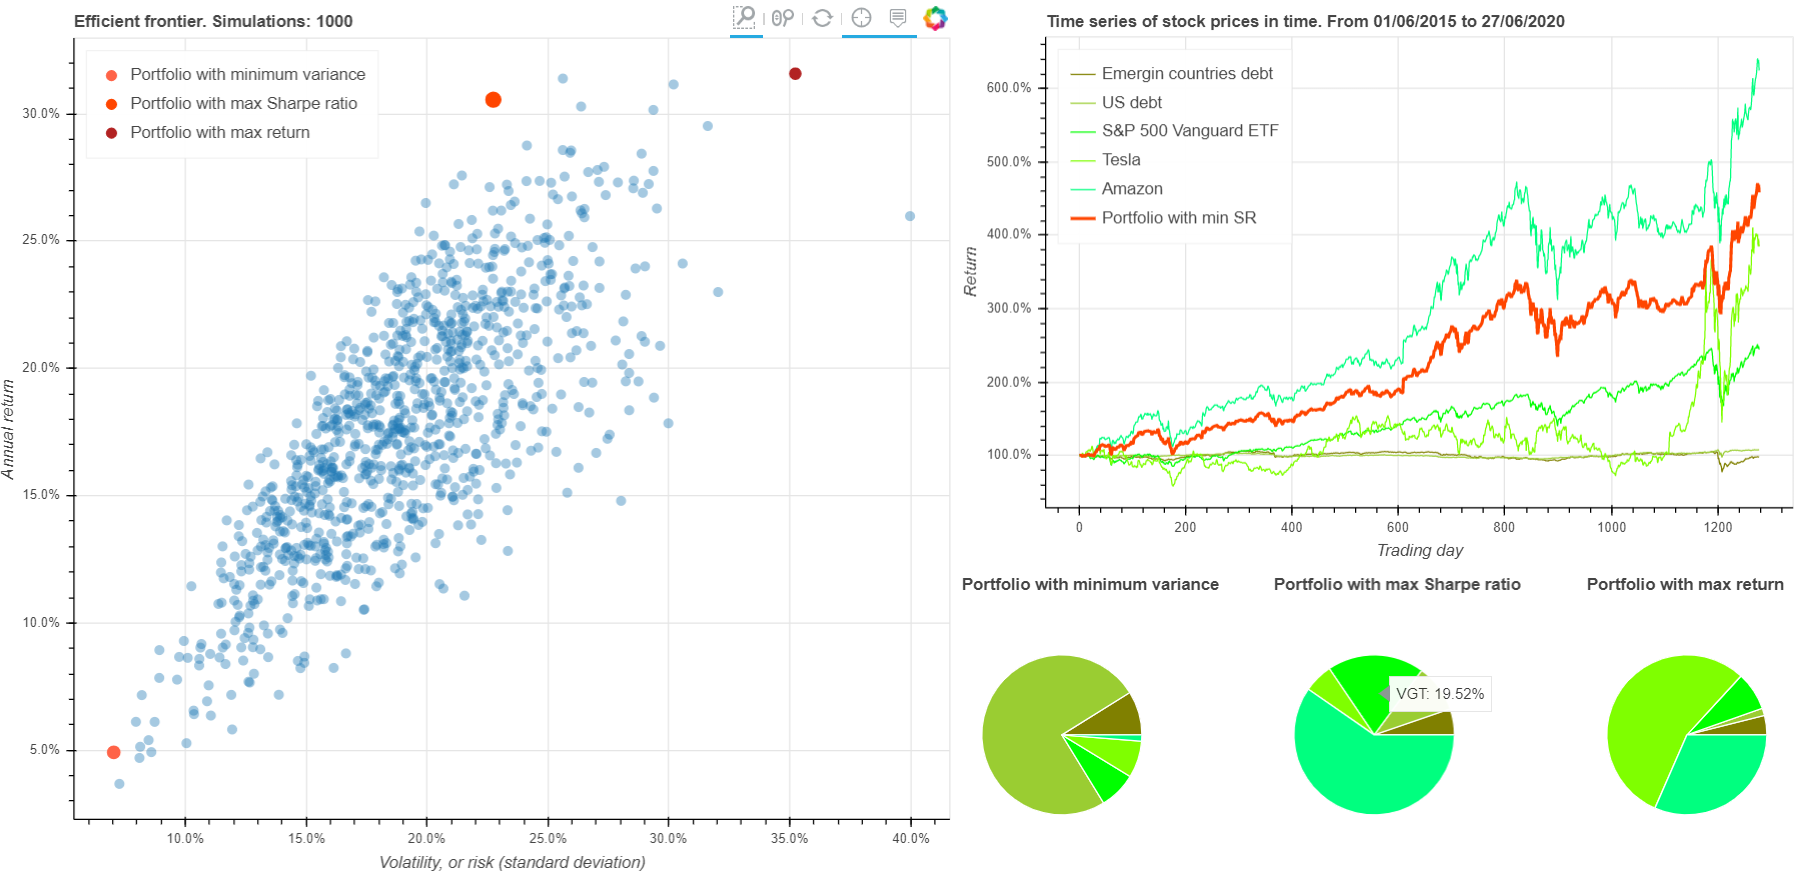

In [42]:
## MAIN BODY 

# Download historical data
start = int(time.mktime(datetime.strptime(start_date, "%d/%m/%Y").timetuple()))
end = int(time.mktime(datetime.strptime(end_date, "%d/%m/%Y").timetuple()))

data_dict = dict()
i = 0

for stock in ticks:
    
    querystring = {"to": end, "symbol": stock, "from": start, "resolution": 'D'}

    try:
        response = requests.request("GET", url = "https://finnhub-realtime-stock-price.p.rapidapi.com/stock/candle", 
                                    headers = {'x-rapidapi-host': "finnhub-realtime-stock-price.p.rapidapi.com",
                                               'x-rapidapi-key': api_key}, params=querystring)
        
        data = response.json()
        df = pd.DataFrame.from_dict(data)
        df = df.drop(columns=['s', 'h', 'l', 'o', 'v'])

        # Output time zone: Universal Time Coordinated
        df['time'] = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in df.t.values]

    except:
        raise ValueError("No data found for " + querystring['symbol'])

    i += 1

    # The download limit is 10 requests per minute
    if i % 10 == 0:
        time.sleep(60)
            
    data_dict[stock] = df

data_to_concat = []

# PRE PROCESS DATA TO A FRIENDLY FORMAT
for key in data_dict:
    data_dict[key] = data_dict[key].rename(columns={"c": key})
    data_to_concat.append(data_dict[key])

price_data = pd.concat(data_to_concat, axis=1, join='inner')
price_data = price_data.loc[:,~price_data.columns.duplicated()].drop(columns='t').set_index('time')

log_ret = np.log(price_data/price_data.shift(1))

cov_mat = log_ret.cov() * 252

all_wts = np.zeros((num_port, len(price_data.columns)))
port_returns = np.zeros((num_port))
port_risk = np.ones((num_port))
sharpe_ratio = np.zeros((num_port))


# SIMULATE x PORTFOLIOS

np.random.seed(42)

for i in range(num_port):

    # Portfolio weights
    wts = np.random.uniform(size=len(price_data.columns))
    wts = wts / np.sum(wts)
    all_wts[i, :] = wts

    # Portfolio Return
    port_ret = np.sum(log_ret.mean() * wts)
    port_ret = (port_ret + 1) ** 252 - 1
    port_returns[i] = port_ret

    # Portfolio Risk
    port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
    port_risk[i] = port_sd

    # Portfolio Sharpe Ratio, assuming 0% Risk Free Rate
    sr = port_ret / port_sd
    sharpe_ratio[i] = sr

    # Save portfolios of interest (min var, max return and max SR)
    if sr >= max(sharpe_ratio[0:-1]):
        max_sr_ret = port_ret
        max_sr_risk = port_sd
        max_sr_w = wts
        max_sr = sr

    if port_ret >= max(port_returns[0:-1]):
        max_ret_ret = port_ret
        max_ret_risk = port_sd
        max_ret_w = wts

    if port_sd <= min(port_risk[0:-1]):
        min_var_ret = port_ret
        min_var_risk = port_sd
        min_var_w = wts


## PLOTS

# Modern Portfolio Theory: the efficient frontier
p = figure(plot_height=700, plot_width=770, title="Efficient frontier. Simulations: " + str(num_port),
           tools='box_zoom,wheel_zoom,reset', toolbar_location='above')
p.add_tools(CrosshairTool(line_alpha=1, line_color='lightgray', line_width=1))
p.add_tools(HoverTool(tooltips=None))
source = ColumnDataSource(data=dict(risk=port_risk, profit=port_returns))
p.circle(x='risk', y='profit', source=source, line_alpha=0, hover_color='navy', alpha=0.4, hover_alpha=1, size=8)
p.circle(min_var_risk, min_var_ret, color='tomato', legend='Portfolio with minimum variance', size=10)
p.circle(max_sr_risk, max_sr_ret, color='orangered', legend='Portfolio with max Sharpe ratio', size=12)
p.circle(max_ret_risk, max_ret_ret, color='firebrick', legend='Portfolio with max return', size=9)
p.legend.location = "top_left"
p.xaxis.axis_label = 'Volatility, or risk (standard deviation)'
p.yaxis.axis_label = 'Annual return'
p.xaxis[0].formatter = NumeralTickFormatter(format="0.0%")
p.yaxis[0].formatter = NumeralTickFormatter(format="0.0%")

# Portfolio composition. Min variance, max SR, max return
def plot_portfolio_composition(ticks, weights, plot_name):

    x = dict()
    for i in range(len(ticks)):
        x[ticks[i]] = weights[i]

    color_list = [ "olive", "yellowgreen", "lime", "chartreuse", "springgreen", "lightgreen", "darkseagreen",
                   "seagreen", "green", "darkgreen"]

    plot_data = pd.Series(x).reset_index(name='value').rename(columns={'index': 'stock'})
    plot_data['angle'] = plot_data['value'] / plot_data['value'].sum() * 2 * math.pi
    plot_data['color'] = color_list[0:len(weights)]
    p = figure(plot_height=250, plot_width=250, title=plot_name, toolbar_location=None,
                      tools="hover", tooltips="@stock: @value{%0.1f}", x_range=(-0.5, 1.0))
    p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
                   line_color="white", color='color', source=plot_data)
    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None
    p.outline_line_color = None

    return p

p_minvar = plot_portfolio_composition(ticks, min_var_w, "Portfolio with minimum variance")
p_maxsr = plot_portfolio_composition(ticks, max_sr_w, "Portfolio with max Sharpe ratio")
p_maxret = plot_portfolio_composition(ticks, max_ret_w, "Portfolio with max return")


# Stock prices over time
color_list = ["olive", "yellowgreen", "lime", "chartreuse", "springgreen", "lightgreen", "darkseagreen",
              "seagreen", "green", "darkgreen"]

p_time = figure(plot_height=450, plot_width=675, toolbar_location=None, tools="",
                title='Time series of stock prices in time. From ' + start_date + ' to ' + end_date)

i = 0
val_min_var = 0
val_max_shr = 0
val_max_ret = 0

for tick in ticks:
    p_time.line(range(0, len(price_data[tick])), list(price_data[tick]/(price_data[tick][0])),
                color=color_list[i], line_width=1, legend=line_name[i]) 

    val_max_shr += price_data[tick] / (price_data[tick][0]) * max_sr_w[i]

    i += 1

p_time.line(range(0, len(price_data[ticks[0]])), list(val_max_shr), legend="Portfolio with min SR",
            color='orangered', line_width=2.5)

p_time.legend.location = "top_left"
p_time.yaxis[0].formatter = NumeralTickFormatter(format="0.0%")
p_time.xaxis.axis_label = 'Trading day'
p_time.yaxis.axis_label = 'Return'

# Create dashboard and open new window to show results
layout = row([p, column([p_time, row([p_minvar, p_maxsr, p_maxret])])])
show(layout)